In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Train_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of normal samples: {len(df[df['class'] == 'normal'])}")
print(f"Number of anomaly samples: {len(df[df['class'] == 'anomaly'])}")

categorical_cols = ['protocol_type', 'service', 'flag', 'class']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Dataset shape: (25192, 42)
Number of normal samples: 13449
Number of anomaly samples: 11743
Training set shape: (20153, 41)
Testing set shape: (5039, 41)


In [23]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

k = 20  
selector = SelectKBest(f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]
print(f"Selected features: {selected_features.tolist()}")

plt.figure(figsize=(12, 8))
scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values('Score', ascending=False)
sns.barplot(x='Score', y='Feature', data=feature_scores.head(20))
plt.title('Top 20 Features by F-score')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()


Selected features: ['protocol_type', 'service', 'flag', 'logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_rf_model = grid_search.best_estimator_
print(f"Best Random Forest parameters: {grid_search.best_params_}")

y_pred_rf = best_rf_model.predict(X_test_selected)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png')
plt.close()

plt.figure(figsize=(12, 8))
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
selected_feature_names = selected_features.tolist()
plt.bar(range(X_train_selected.shape[1]), importances[indices])
plt.xticks(range(X_train_selected.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.close()


Best Random Forest parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Results:
Accuracy: 0.9948
Precision: 0.9933
Recall: 0.9970
F1 Score: 0.9952

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2349
           1       0.99      1.00      1.00      2690

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



In [26]:
from sklearn.svm import SVC

svm_model = SVC(random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_svm_model = grid_search.best_estimator_
print(f"Best SVM parameters: {grid_search.best_params_}")

y_pred_svm = best_svm_model.predict(X_test_selected)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("\nSVM Results:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')
plt.close()


Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

SVM Results:
Accuracy: 0.9815
Precision: 0.9790
Recall: 0.9866
F1 Score: 0.9828

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2349
           1       0.98      0.99      0.98      2690

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_gb_model = grid_search.best_estimator_
print(f"Best Gradient Boosting parameters: {grid_search.best_params_}")

y_pred_gb = best_gb_model.predict(X_test_selected)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

print("\nGradient Boosting Results:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.tight_layout()
plt.savefig('gb_confusion_matrix.png')
plt.close()

plt.figure(figsize=(12, 8))
importances = best_gb_model.feature_importances_
indices = np.argsort(importances)[::-1]
selected_feature_names = selected_features.tolist()
plt.bar(range(X_train_selected.shape[1]), importances[indices])
plt.xticks(range(X_train_selected.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.savefig('gb_feature_importance.png')
plt.close()


Best Gradient Boosting parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

Gradient Boosting Results:
Accuracy: 0.9952
Precision: 0.9952
Recall: 0.9959
F1 Score: 0.9955

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2349
           1       1.00      1.00      1.00      2690

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test.values.reshape(-1, 1))

def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

nn_model = build_model(X_train_selected.shape[1])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_selected, y_train_onehot,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

y_pred_proba_nn = nn_model.predict(X_test_selected)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)
y_test_nn = np.argmax(y_test_onehot, axis=1)

accuracy_nn = accuracy_score(y_test_nn, y_pred_nn)
precision_nn = precision_score(y_test_nn, y_pred_nn)
recall_nn = recall_score(y_test_nn, y_pred_nn)
f1_nn = f1_score(y_test_nn, y_pred_nn)

print("\nNeural Network Results:")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_nn, y_pred_nn))


Epoch 1/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.9282 - loss: 0.1946 - val_accuracy: 0.9722 - val_loss: 0.0676
Epoch 2/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.9679 - loss: 0.0790 - val_accuracy: 0.9774 - val_loss: 0.0596
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.9711 - loss: 0.0695 - val_accuracy: 0.9772 - val_loss: 0.0586
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.9736 - loss: 0.0641 - val_accuracy: 0.9799 - val_loss: 0.0566
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.9754 - loss: 0.0606 - val_accuracy: 0.9792 - val_loss: 0.0523
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9774 - loss: 0.0570 - val_accuracy: 0.9777 - val_loss: 0.0543
Epoch 7/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9743 - loss: 0.0589 - val_accuracy: 0.9782 - val_loss: 0.0513
Epoch 8/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.9777 - loss: 0.0575 - 

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_knn_model = grid_search.best_estimator_
print(f"Best KNN parameters: {grid_search.best_params_}")

y_pred_knn = best_knn_model.predict(X_test_selected)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print("\nKNN Results:")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png')
plt.close()


Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

KNN Results:
Accuracy: 0.9913
Precision: 0.9918
Recall: 0.9918
F1 Score: 0.9918

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2349
           1       0.99      0.99      0.99      2690

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



In [30]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': ['balanced', None]
}

param_grid_lr = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'class_weight': ['balanced', None]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'class_weight': ['balanced', None]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2', None], 'solver': ['lbfgs'], 'class_weight': ['balanced', None]}
]

grid_search = GridSearchCV(lr_model, param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_lr_model = grid_search.best_estimator_
print(f"Best Logistic Regression parameters: {grid_search.best_params_}")

y_pred_lr = best_lr_model.predict(X_test_selected)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.savefig('lr_confusion_matrix.png')
plt.close()

if hasattr(best_lr_model, 'coef_'):
    plt.figure(figsize=(12, 8))
    coef = best_lr_model.coef_[0]
    indices = np.argsort(np.abs(coef))[::-1]
    selected_feature_names = selected_features.tolist()
    plt.bar(range(X_train_selected.shape[1]), np.abs(coef[indices]))
    plt.xticks(range(X_train_selected.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)
    plt.title('Feature Importance - Logistic Regression')
    plt.tight_layout()
    plt.savefig('lr_feature_importance.png')
    plt.close()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty

Best Logistic Regression parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression Results:
Accuracy: 0.9456
Precision: 0.9342
Recall: 0.9662
F1 Score: 0.9499

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2349
           1       0.93      0.97      0.95      2690

    accuracy                           0.95      5039
   macro avg       0.95      0.94      0.95      5039
weighted avg       0.95      0.95      0.95      5039



In [31]:
models = ['Random Forest', 'SVM', 'KNN', 'Logistic Regression', 'Neural Network', 'Gradient Boosting']
accuracy_scores = [accuracy_rf, accuracy_svm, accuracy_knn, accuracy_lr, accuracy_nn, accuracy_gb]
precision_scores = [precision_rf, precision_svm, precision_knn, precision_lr, precision_nn, precision_gb]
recall_scores = [recall_rf, recall_svm, recall_knn, recall_lr, recall_nn, recall_gb]
f1_scores = [f1_rf, f1_svm, f1_knn, f1_lr, f1_nn, f1_gb]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

print("\nModel Comparison:")
print(comparison_df.sort_values('F1 Score', ascending=False))



Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
5    Gradient Boosting  0.995237   0.995171  0.995911  0.995541
0        Random Forest  0.994840   0.993333  0.997026  0.995176
2                  KNN  0.991268   0.991822  0.991822  0.991822
4       Neural Network  0.987101   0.982714  0.993309  0.987983
1                  SVM  0.981544   0.978975  0.986617  0.982781
3  Logistic Regression  0.945624   0.934220  0.966171  0.949927


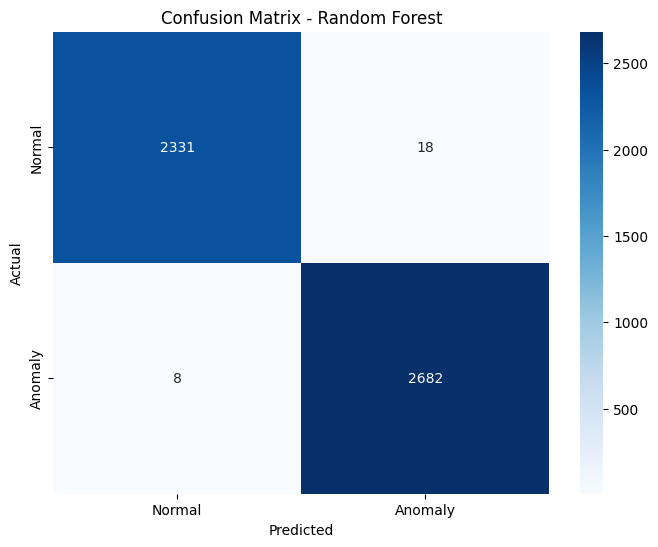

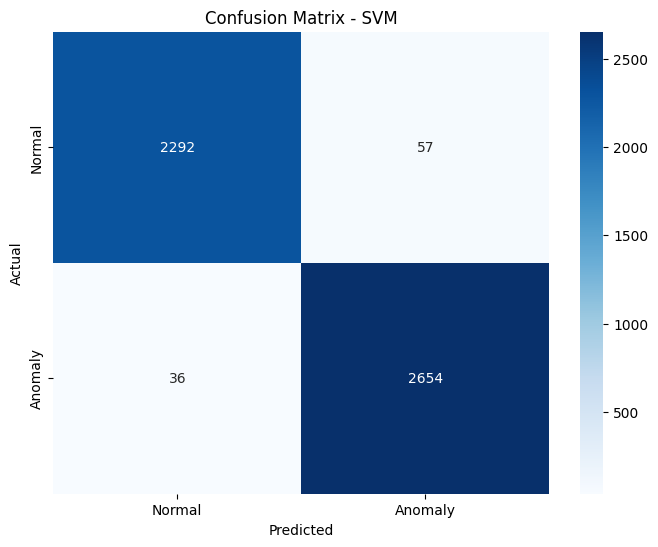

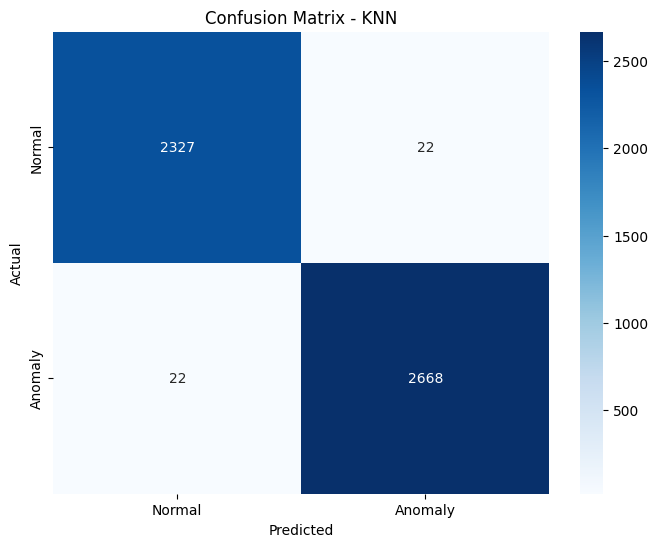

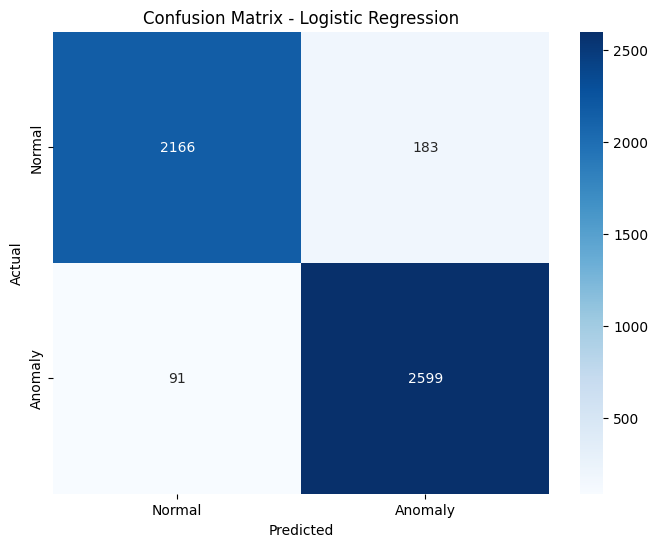

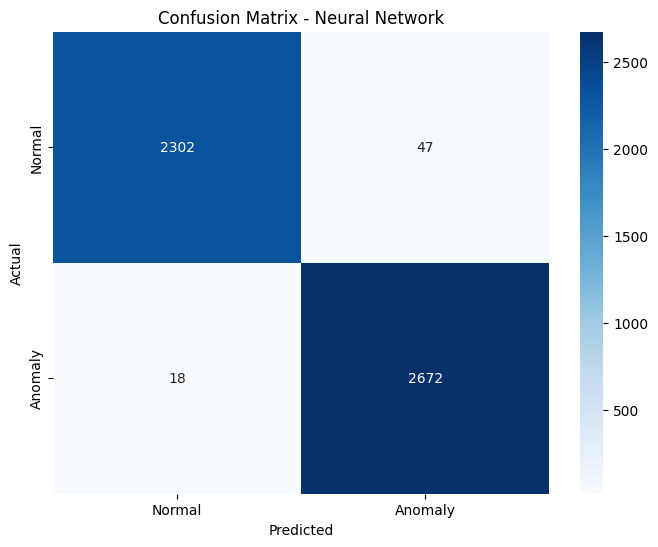

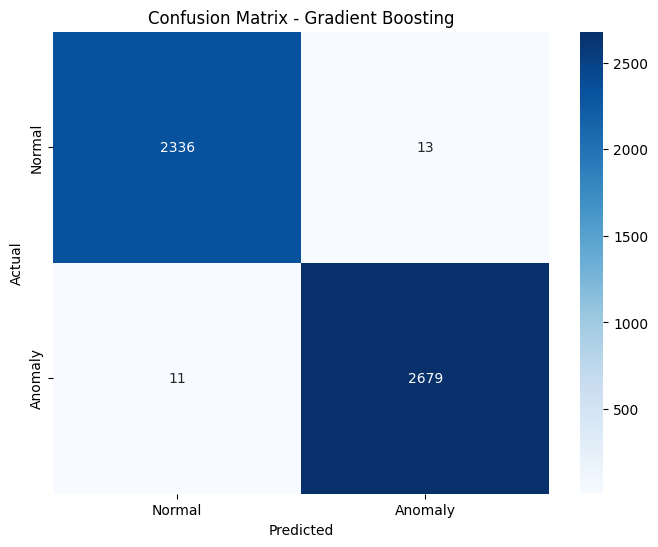

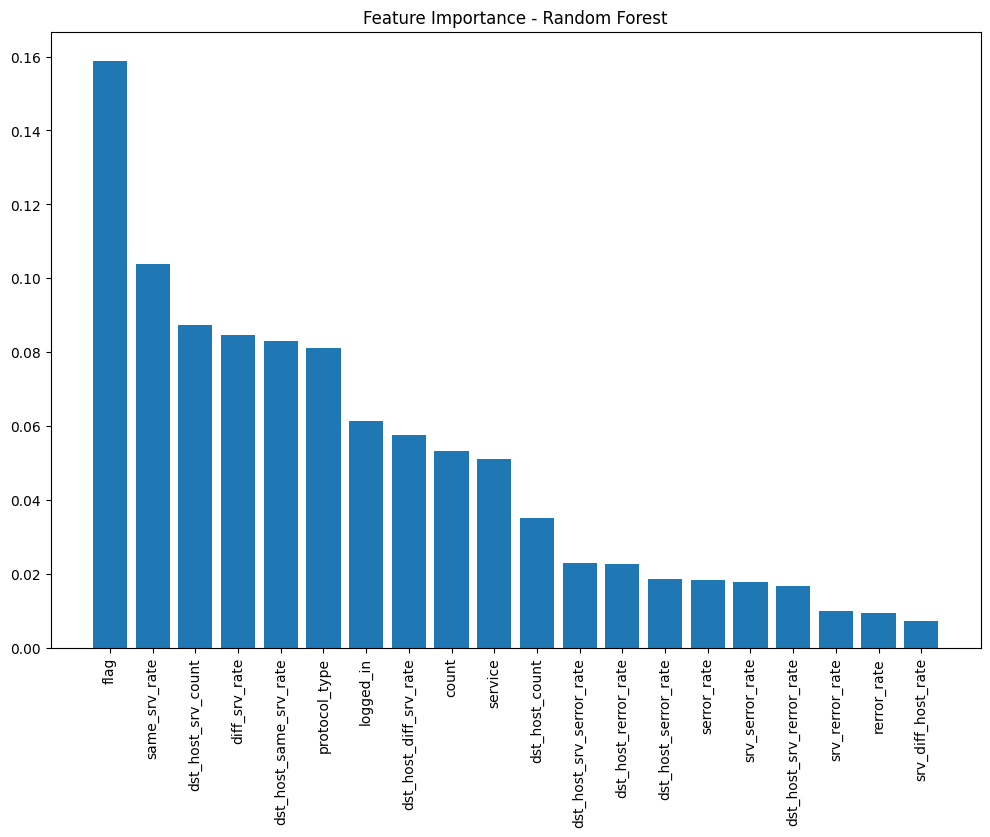

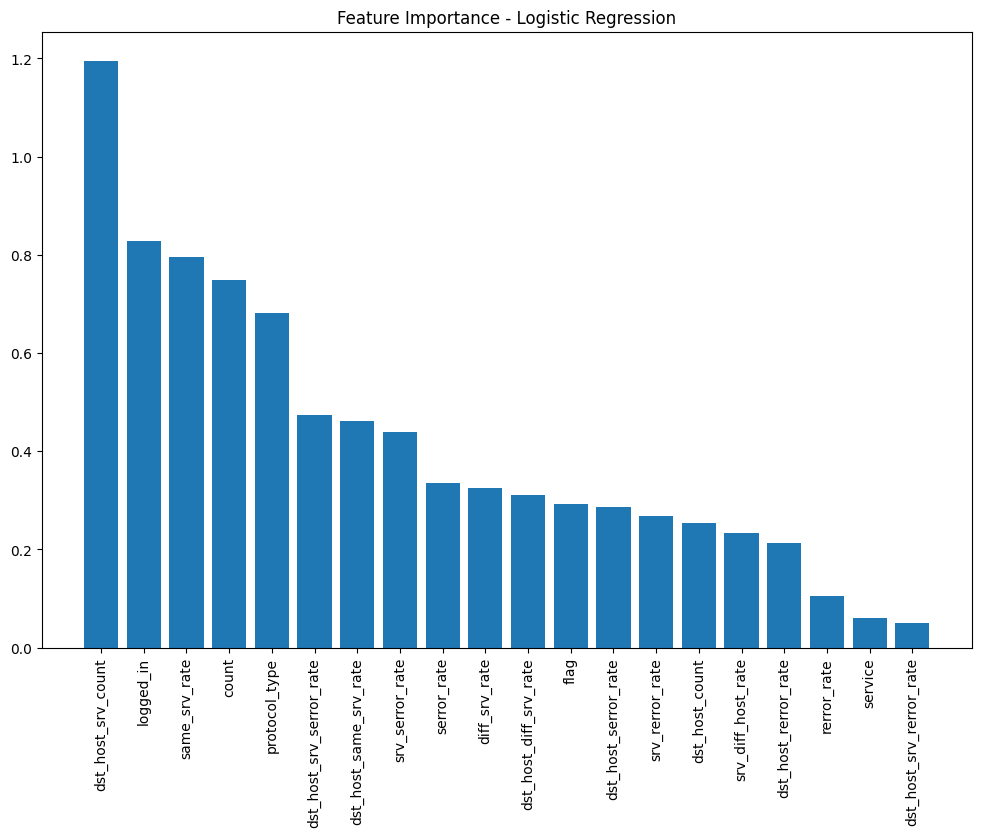

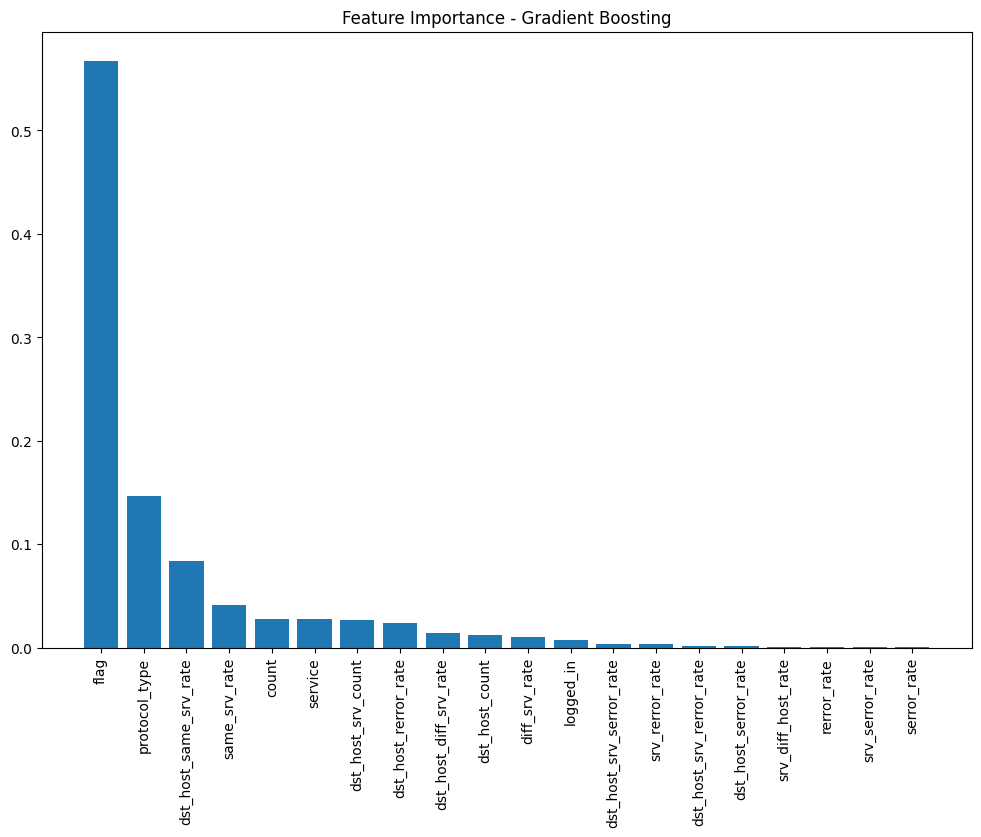

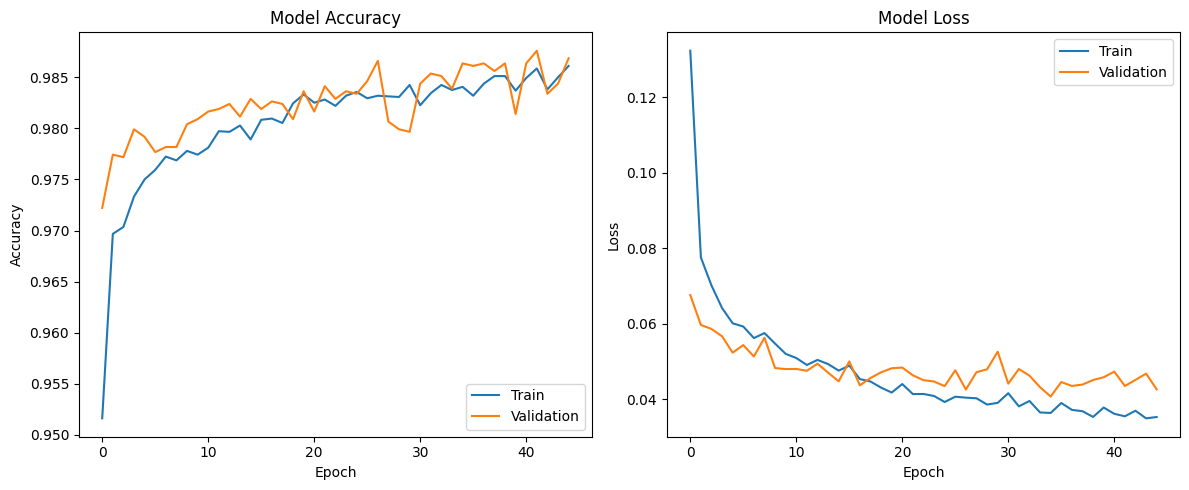

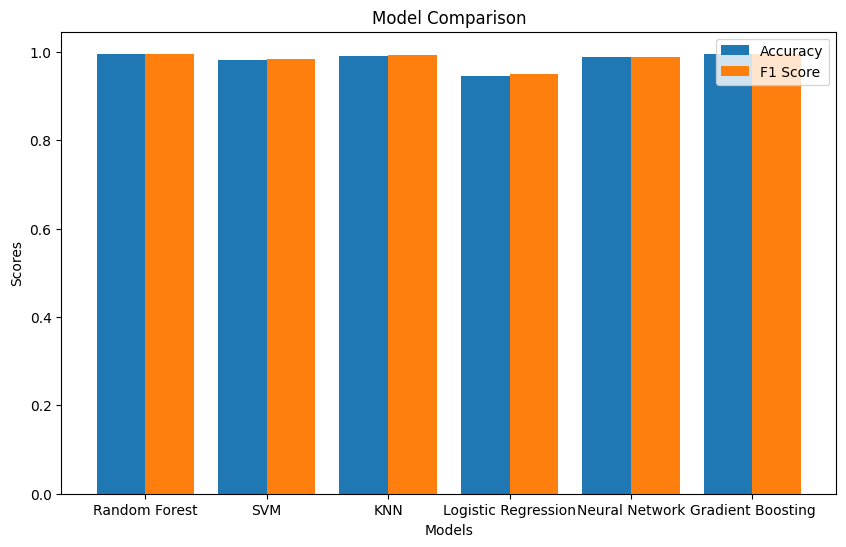

In [33]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Function to plot feature importance
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Feature importance not available for {model_name}")
        return

    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance - {model_name}')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test_nn, y_pred_nn, "Neural Network")
plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")

# Plot feature importance
plot_feature_importance(best_rf_model, selected_features.tolist(), "Random Forest")
plot_feature_importance(best_lr_model, selected_features.tolist(), "Logistic Regression")
plot_feature_importance(best_gb_model, selected_features.tolist(), "Gradient Boosting")

# For Neural Network training history visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Compare all models using a bar chart
models = ['Random Forest', 'SVM', 'KNN', 'Logistic Regression', 'Neural Network', 'Gradient Boosting']
accuracy_scores = [accuracy_rf, accuracy_svm, accuracy_knn, accuracy_lr, accuracy_nn, accuracy_gb]
f1_scores = [f1_rf, f1_svm, f1_knn, f1_lr, f1_nn, f1_gb]

plt.figure(figsize=(10, 6))
x = range(len(models))
plt.bar([i - 0.2 for i in x], accuracy_scores, width=0.4, label='Accuracy', align='center')
plt.bar([i + 0.2 for i in x], f1_scores, width=0.4, label='F1 Score', align='center')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()
